In [1]:
!pip install --upgrade gym pyvirtualdisplay ipykernel > /dev/null 2>&1

In [19]:
!pip install numpy==1.19.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 44.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for numpy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for numpy
Failed to build numpy
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (numpy)


In [22]:
print("NumPy вер:", np.__version__)
print("Gym вер:", gym.__version__)
print("PyTorch вер:", torch.__version__)

NumPy вер: 2.0.2
Gym вер: 0.26.2
PyTorch вер: 2.6.0+cu124


In [47]:
import torch
import gym
import numpy as np
from collections import defaultdict
from IPython import display as ipythondisplay
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [70]:
env = gym.make('MountainCar-v0')

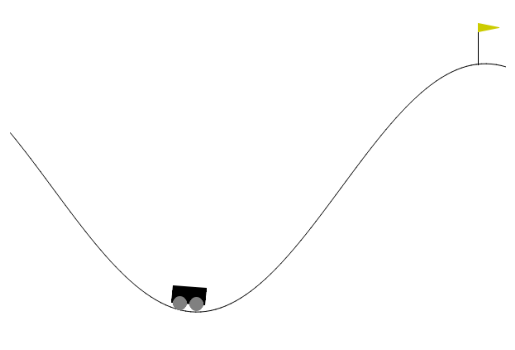

In [147]:
def display(env):
    env.reset()
    img = plt.imshow(env.render())
    plt.axis('off')
    plt.show()
env = gym.make('MountainCar-v0', render_mode="rgb_array")
display(env)
env.close()

In [146]:
state, _ = env.reset()
print(state)

[-0.5812789  0.       ]


In [88]:
for step in range(5):
    action = env.action_space.sample()  # Случайное действие
    state, reward, done, truncated, info = env.step(action)
    print(f"Step {step + 1}: Action={action}, State={state}, Reward={reward}, Done={done}")
    if done or truncated:
        print("Episode finished!")
        break

Step 1: Action=2, State=[-4.2739928e-01  2.9056688e-04], Reward=-1.0, Done=False
Step 2: Action=0, State=[-0.42882022 -0.00142096], Reward=-1.0, Done=False
Step 3: Action=1, State=[-0.43094248 -0.00212226], Reward=-1.0, Done=False
Step 4: Action=1, State=[-0.43375075 -0.00280826], Reward=-1.0, Done=False
Step 5: Action=0, State=[-0.43822473 -0.00447399], Reward=-1.0, Done=False


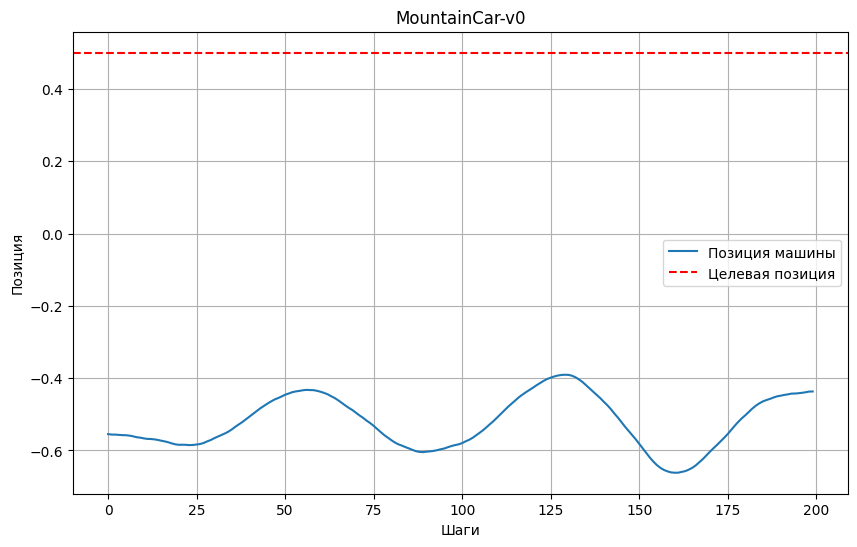

In [149]:
positions = []  # Список для хранения позиций машины

# Выполнение эпизода
done = False
truncated = False
while not (done or truncated):
    action = env.action_space.sample()
    state, reward, done, truncated, info = env.step(action)
    positions.append(state[0])

# Визуализация позиций машины
plt.figure(figsize=(10, 6))
plt.plot(positions, label="Позиция машины")
plt.axhline(y=0.5, color='r', linestyle='--', label="Целевая позиция")
plt.title("MountainCar-v0")
plt.xlabel("Шаги")
plt.ylabel("Позиция")
plt.legend()
plt.grid()
plt.show()

# Закрытие среды
env.close()

In [179]:
position_bins = np.linspace(-1.2, 0.6, 30)  # Увеличили количество интервалов
velocity_bins = np.linspace(-0.07, 0.07, 30)
def discretize_state(state):
    position, velocity = state
    position_idx = np.digitize(position, position_bins) - 1
    velocity_idx = np.digitize(velocity, velocity_bins) - 1
    return (position_idx, velocity_idx)

In [180]:
def run_episode(env, Q, epsilon, n_action):
    """
    Выполняет эпизод, следуя ε-жадной стратегии
    @param env: имя окружающей среды OpenAI Gym
    @param Q: Q-функция
    @param epsilon: компромисс между исследованием и использованием
    @param n_action: пространство действий
    @return: результирующие состояния, действия и вознаграждения для всего эпизода
    """
    state, _ = env.reset()  # сброс среды и получение начального состояния
    state = discretize_state(state)
    rewards = []  # список для хранения вознаграждений
    actions = []  # список для хранения действий
    states = []  # список для хранения состояний
    while True:
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q[state]).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()

        actions.append(action)
        states.append(state)

        state, reward, done, truncated, info = env.step(action)
        state = discretize_state(state)
        rewards.append(reward)

        if done or truncated:
            break

    return states, actions, rewards

In [184]:
# Реализация управления МК с ε-жадной единой стратегией
import matplotlib.pyplot as plt

def mc_control_epsilon_greedy(env, gamma, n_episode, epsilon_start, epsilon_end, epsilon_decay):
    """
    Строит оптимальную ε-жадную стратегию методом управления МК с единой стратегией
    @param env: имя окружающей среды OpenAI Gym
    @param gamma: коэффициент обесценивания
    @param n_episode: количество эпизодов
    @param epsilon: компромисс между исследованием и использованием
    @return: оптимальные Q-функция и стратегия
    """
    n_action = env.action_space.n  # количество возможных действий
    G_sum = defaultdict(float)  # сумма возвратов для каждого состояния-действия
    N = defaultdict(int)  # количество посещений для каждого состояния-действия
    Q = defaultdict(lambda: torch.rand(n_action) * 0.01)  # инициализация Q-функции

    total_rewards = []  # список для хранения наград (побочная переменная)
    all_positions = []  # список для хранения позиций автомобиля во всех эпизодах

    for episode in range(n_episode):
        epsilon = max(epsilon_end, epsilon_start * (epsilon_decay ** episode))
        states_t, actions_t, rewards_t = run_episode(env, Q, epsilon, n_action)  # Выполнение эпизода
        return_t = 0  # инициализация возврата для текущего эпизода
        G = {}  # словарь для хранения возвратов для каждого состояния-действия

        total_reward = sum(rewards_t)  # общее вознаграждение за эпизод
        total_rewards.append(total_reward)

        # Сбор позиций автомобиля в текущем эпизоде
        positions = [state[0] for state in states_t]  # state[0] — это позиция автомобиля
        all_positions.append(positions)

        # Обратный проход по эпизоду для вычисления возвратов
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t  # вычисление возврата с учетом обесценивания
            G[(state_t, action_t)] = return_t  # сохранение возврата для текущего состояния-действия

        # Обновление Q-функции на основе возвратов
        for state_action, return_t in G.items():
            state, action = state_action
            G_sum[state_action] += return_t
            N[state_action] += 1
            alpha = 1 / N[state_action]  # Скорость обучения
            Q[state][action] += alpha * (return_t - Q[state][action])

        # Вывод прогресса каждые 100 эпизодов
        if (episode + 1) % 100 == 0:
            avg_reward = sum(total_rewards[-100:]) / 100  # среднее вознаграждение за последние 100 эпизодов
            print(f"Эпизод {episode + 1}/{n_episode}, Среднее вознаграждение за 100 эпизодов: {avg_reward:.2f}")

    # Формирование оптимальной стратегии на основе Q-функции
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()  # выбор действия с максимальным Q-значением

    # Построение графика позиций
    plot_positions(all_positions)

    return Q, policy  # возврат оптимальных Q-функции и стратегии

In [185]:
def plot_positions(all_positions):
    plt.figure(figsize=(12, 6))
    for i, positions in enumerate(all_positions):
        if i % 100 == 0:  # Рисуем только каждый 100-й эпизод для читаемости графика
            plt.plot(positions, label=f"Эпизод {i + 1}")
    plt.axhline(y=0.5, color='r', linestyle='--', label="Цель")  # Линия цели
    plt.xlabel("Шаги")
    plt.ylabel("Позиция автомобиля")
    plt.title("Изменение позиции")
    plt.legend()
    plt.show()

In [188]:
gamma = 0.99
n_episode = 50000
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.99

Внизу изображение, в целом проблема заключалась в том что делая по 10к эпизодов всегда было в результате -200, и решил поэксперементировать с параметрами, вывел график для 1000 эпизодов и судя по позиции, он все таки двигался.

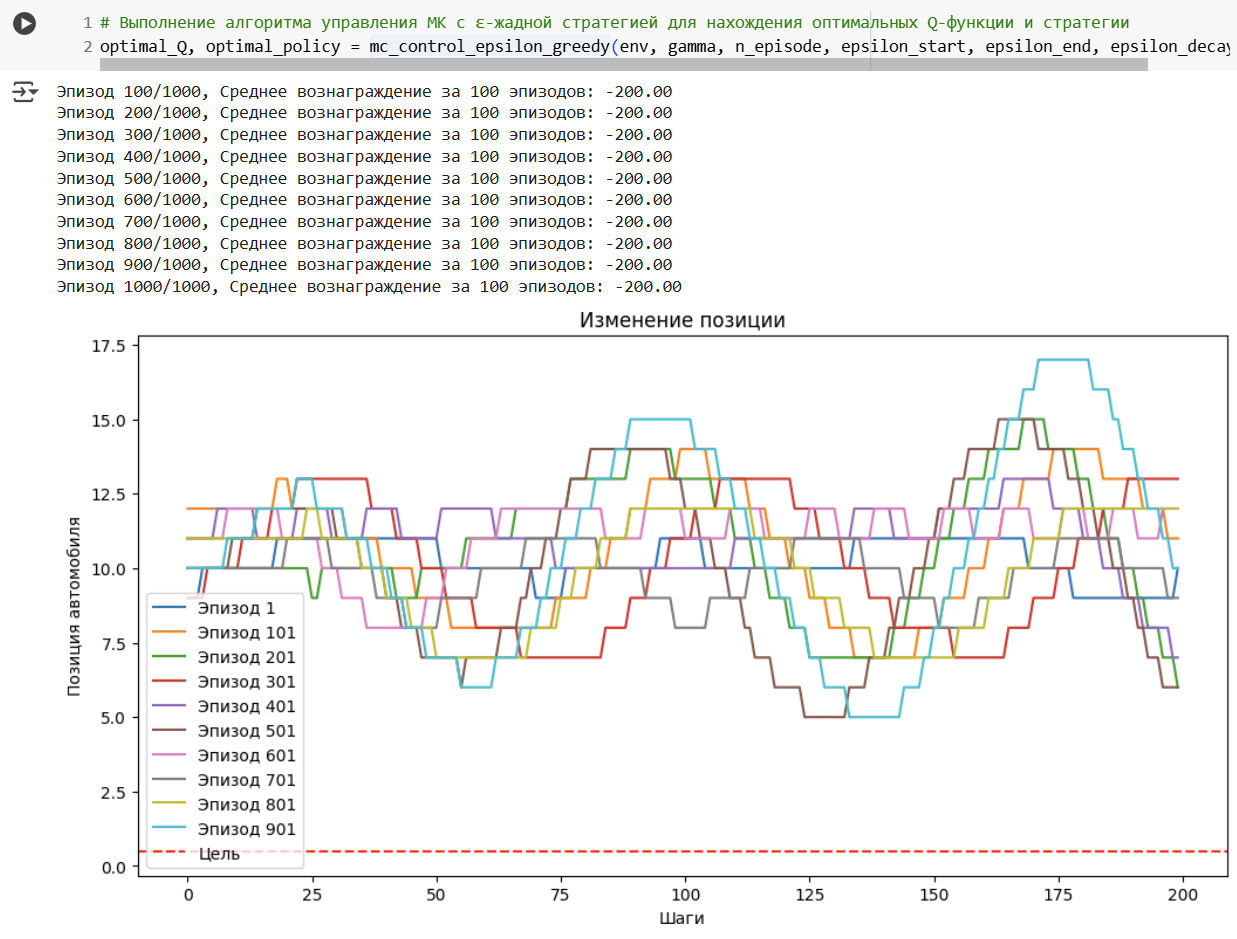

Вот на коде ниже возникала ошибка постоянно AttributeError: module 'numpy' has no attribute 'bool8'
Каким то магическим образом при переустановке зависимостей она пропадает

Эпизод 100/50000, Среднее вознаграждение за 100 эпизодов: -200.00
Эпизод 200/50000, Среднее вознаграждение за 100 эпизодов: -200.00
Эпизод 300/50000, Среднее вознаграждение за 100 эпизодов: -200.00
Эпизод 400/50000, Среднее вознаграждение за 100 эпизодов: -200.00
Эпизод 500/50000, Среднее вознаграждение за 100 эпизодов: -200.00
Эпизод 600/50000, Среднее вознаграждение за 100 эпизодов: -200.00
Эпизод 700/50000, Среднее вознаграждение за 100 эпизодов: -200.00
Эпизод 800/50000, Среднее вознаграждение за 100 эпизодов: -200.00
Эпизод 900/50000, Среднее вознаграждение за 100 эпизодов: -200.00
Эпизод 1000/50000, Среднее вознаграждение за 100 эпизодов: -200.00
Эпизод 1100/50000, Среднее вознаграждение за 100 эпизодов: -200.00
Эпизод 1200/50000, Среднее вознаграждение за 100 эпизодов: -200.00
Эпизод 1300/50000, Среднее вознаграждение за 100 эпизодов: -200.00
Эпизод 1400/50000, Среднее вознаграждение за 100 эпизодов: -200.00
Эпизод 1500/50000, Среднее вознаграждение за 100 эпизодов: -200.00
Эпиз

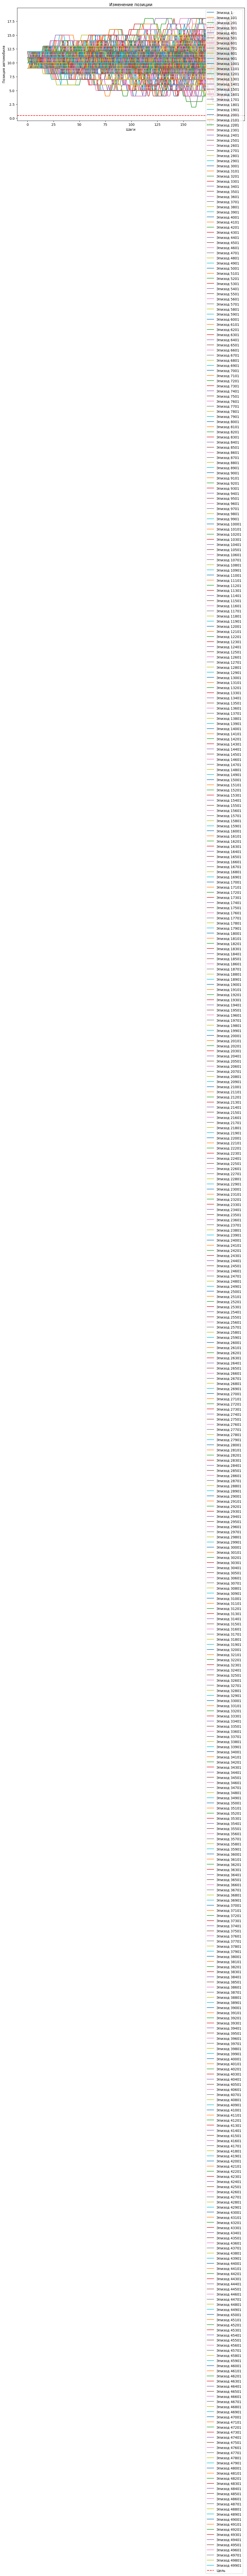

In [189]:
# Выполнение алгоритма управления МК с ε-жадной стратегией для нахождения оптимальных Q-функции и стратегии
optimal_Q, optimal_policy = mc_control_epsilon_greedy(env, gamma, n_episode, epsilon_start, epsilon_end, epsilon_decay)

И все таки машинка исследует пространство =)

In [190]:
# Снова сымитируем 10000 эпизодов
n_episode = 10000
n_win_optimal = 0
n_lose_optimal = 0

In [193]:
# Определение функции-обертки, которая выполняет один эпизод, следуя заданной стратегии, и возвращает полное вознаграждение
def simulate_episode(env, policy):
    state, _ = env.reset()
    state = discretize_state(state)
    total_reward = 0

    while True:
        action = policy[state]
        state, reward, done, truncated, info = env.step(action)
        state = discretize_state(state)
        total_reward += reward

        if done or truncated:
            return total_reward

In [194]:
for _ in range(n_episode):
    reward = simulate_episode(env, optimal_policy)  # выполнение эпизода с оптимальной стратегией
    if reward == 0:  # MountainCar-v0 дает вознаграждение 0 при достижении цели
        n_win_optimal += 1  # увеличение счетчика выигрышей
    elif reward < 0:  # Если цель не достигнута, вознаграждение отрицательное
        n_lose_optimal += 1  # увеличение счетчика проигрышей

# Вывод результатов
print('Вероятность выигрыша при оптимальной стратегии: {}'.format(n_win_optimal / n_episode))
print('Вероятность проигрыша при оптимальной стратегии: {}'.format(n_lose_optimal / n_episode))

Вероятность выигрыша при оптимальной стратегии: 0.0
Вероятность проигрыша при оптимальной стратегии: 1.0


В целом оно и логично, ведь за 50к эпизодов она так и не смогла дойти до финиша, хотя в некоторых из них была очень близка.

In [212]:
from mpl_toolkits.mplot3d import Axes3D
def plot_mountaincar_value(Q, policy=None):

    # Диапазон позиций автомобиля (от -1.2 до 0.6)
    position_range = np.linspace(-1.2, 0.6, 50)

    # Диапазон скоростей автомобиля (от -0.07 до 0.07)
    velocity_range = np.linspace(-0.07, 0.07, 50)

    # Создание сетки для осей X и Y
    X, Y = np.meshgrid(position_range, velocity_range)

    # Инициализация массива для хранения значений ценности
    values_to_plot = np.zeros_like(X)

    for i in range(len(position_range)):
        for j in range(len(velocity_range)):
            state = (float(position_range[i]), float(velocity_range[j]))  # Преобразование в кортеж с float
            if state in Q:
                if policy is None:
                    values_to_plot[j, i] = max(Q[state])
                else:
                    action = policy.get(state, 0)
                    values_to_plot[j, i] = Q[state][action]
            else:
                values_to_plot[j, i] = 0

    # Визуализация функции ценности
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, values_to_plot, cmap='viridis')

    # Настройка меток осей
    ax.set_xlabel("Позиция")
    ax.set_ylabel("Скорость")
    ax.set_zlabel("Ценность")
    ax.set_title("Функция ценности")

    plt.show()

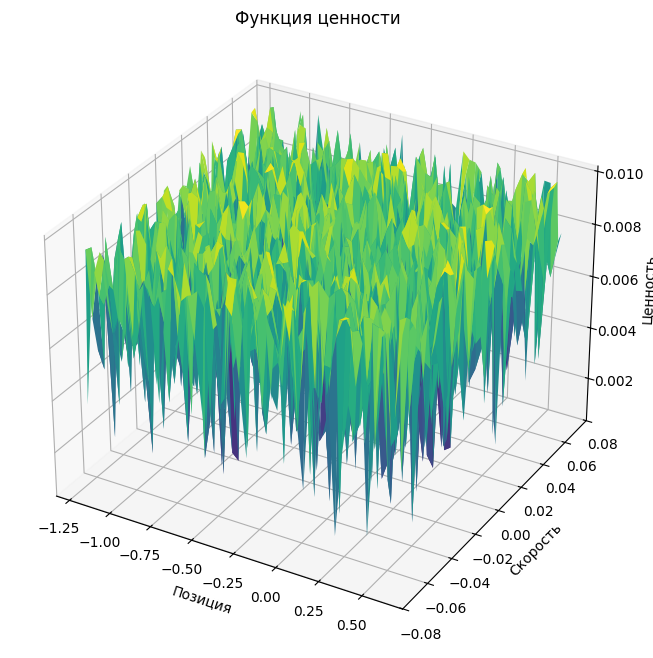

In [213]:
plot_mountaincar_value(optimal_Q)

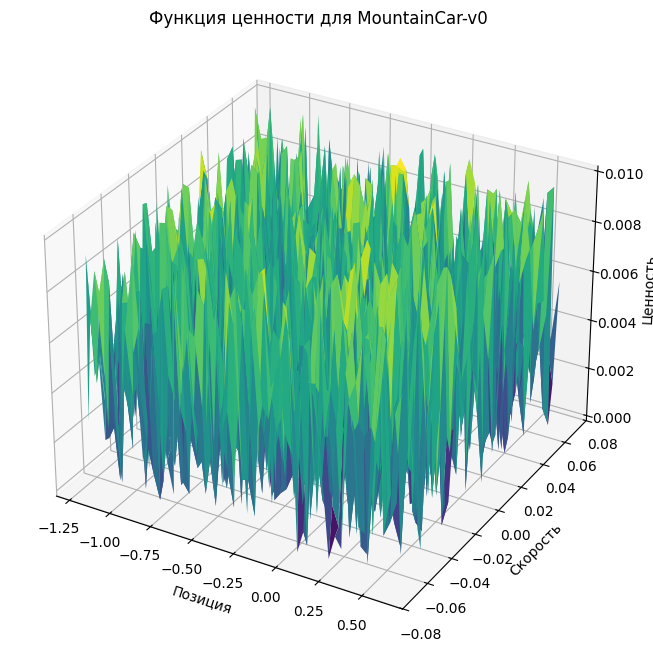

In [211]:
# Визуализация значений V-функции для оптимальной стратегии
plot_mountaincar_value(optimal_Q, optimal_policy)

Вывод: обучение с помощью алгоритма МК с ε-жадной стратегией для данного случая вряд ли можно назвать оптимальным, т.к агент долго исследует пространство, скорей всего из-за внесения "случайного действия" в его активность. Судя по графикам, можно представить картину, что в нашем случае машинка просто катается взад-вперед, постепенно изучая местность, пока не дойдет до пиковой точки слева либо до финиша справа. По результатам 50к эпизодов она так и не смогла достичь финиша, но была предельно близка к нему. Поэтому с уверенностью можно сказать, что увеличение эпизодов со временем позволило бы агенту достичь финиша. 😀